## The assignment

Task 1: Defining the project topic, and RNN models 

Task 2: Implement the selected model. 

Task 3: Tuning the presented models and describing how and why the results get improvement.

Also, you need to compare your final model with one other RNN model.

### Definition of the project

Sunspots are dark spots observed on the surface of the sun whose number and surface area change with time. This lends the phenomenon naturally to a time series analysis problem. Observing and studying sunspots is a good way to understand the solar cycle. The solar cycle is a roughly 11-year cycle of solar activity characterized by changes in the magnetic field activity generated by the sun.Studying the time variation of sunspot numbers provides an easy way to continuously monitor, understand and predict the various effects of the solar cycle.

In this notebook we will be using RNN models on the Sunspot timeseries dataset to spot patterns and make predictions. An RNN model can handle sequential data, accepting the current input data, and previously received inputs.
The Sunspot dataset consists of 3 265 datapoints and has one variable, called 'Monthly Mean Total Sunspot Number', associated with the end of every month for more than 250 years.

### Model selection

We will try out two different models in this project:<br> 
LSTM (Long Short Term Memory)<br>
Simple RNN

### Data preparations

In [1]:
#Importing needed libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

#!pip install tensorflow

In [2]:
df = pd.read_csv("Sunspots.csv")

In [3]:
#Let's have a look at first five rows
df.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [4]:
#The first column does not provide any meaningful information, hence we will drop it
df.drop(columns = 'Unnamed: 0',inplace = True)

In [5]:
#Let's check for missing data
df.isna().sum()

Date                                 0
Monthly Mean Total Sunspot Number    0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3265 entries, 0 to 3264
Data columns (total 2 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Date                               3265 non-null   object 
 1   Monthly Mean Total Sunspot Number  3265 non-null   float64
dtypes: float64(1), object(1)
memory usage: 51.1+ KB


### Exploratory data analysis

In [7]:
#Defining variables
time= df['Date'].to_numpy()
series = df['Monthly Mean Total Sunspot Number'].to_numpy()

In [8]:
#Function to plot series data
def plotter(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Sunspots")

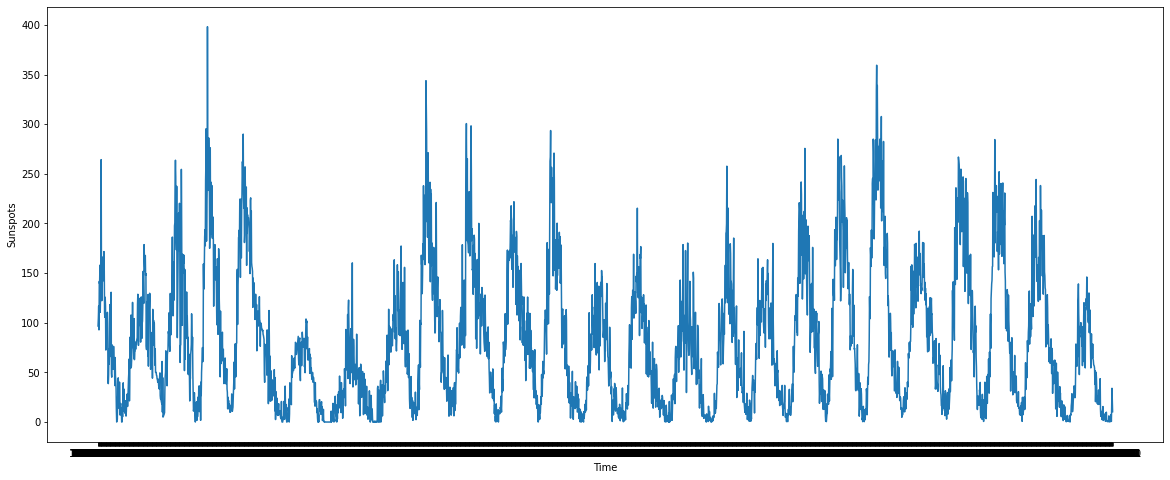

In [9]:
#Plotting the data 
plt.figure(figsize = (20, 8))
plotter(time, series)

### LSTM

In [10]:
#Defining the parameters
window_size = 80
batch_size = 120
shuffle_buffer_size = 1000

In [11]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

#### Model 1

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)
np.random.seed(0)

#Using the windowing operator we can convert a time series problem into a machine learning problem.
#This allows us to use all the additional tools and techniques to train and optimize models.

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

dataset = windowed_dataset(x_train, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)

# Define the model

model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

model_1.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 64)          384       
                                                                 
 lstm (LSTM)                 (None, None, 64)          33024     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          33024     
                                                                 
 lstm_2 (LSTM)               (None, None, 64)          33024     
                                                                 
 dense (Dense)               (None, None, 32)          2080      
                                                                 
 dense_1 (Dense)             (None, None, 16)          528       
                                                                 
 dense_2 (Dense)             (None, None, 1)           1

In [13]:
%%time 
history = model_1.fit(dataset, epochs=100, verbose=1)

Epoch 1/100
25/25 [==============================] - 8s 170ms/step - loss: 30.9367 - mae: 31.4323
Epoch 2/100
25/25 [==============================] - 4s 146ms/step - loss: 20.5015 - mae: 20.9943
Epoch 3/100
25/25 [==============================] - 4s 156ms/step - loss: 19.1199 - mae: 19.6122
Epoch 4/100
25/25 [==============================] - 4s 148ms/step - loss: 18.1957 - mae: 18.6876
Epoch 5/100
25/25 [==============================] - 4s 158ms/step - loss: 17.5492 - mae: 18.0401
Epoch 6/100
25/25 [==============================] - 4s 163ms/step - loss: 17.3469 - mae: 17.8375
Epoch 7/100
25/25 [==============================] - 4s 153ms/step - loss: 17.1054 - mae: 17.5963
Epoch 8/100
25/25 [==============================] - 4s 161ms/step - loss: 16.9407 - mae: 17.4314
Epoch 9/100
25/25 [==============================] - 4s 157ms/step - loss: 17.1239 - mae: 17.6146
Epoch 10/100
25/25 [==============================] - 4s 163ms/step - loss: 16.9628 - mae: 17.4540
Epoch 11/100
25/25 

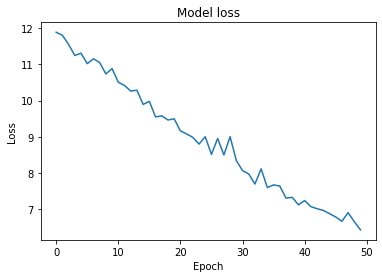

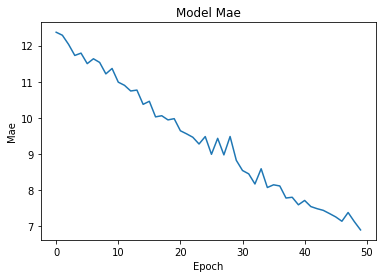

In [14]:
#Plotting loss values
plt.plot(history.history['loss'][50:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

#Plotting mae values
plt.plot(history.history['mae'][50:])
plt.title('Model Mae')
plt.ylabel('Mae')
plt.xlabel('Epoch')
plt.show()

In [15]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [16]:
#Predict the result
rnn_forecast = model_forecast(model_1, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [17]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.title('Forecasting trend')
    plt.xlabel('Date')
    plt.ylabel('Monthly Mean Total Sunspot Number')

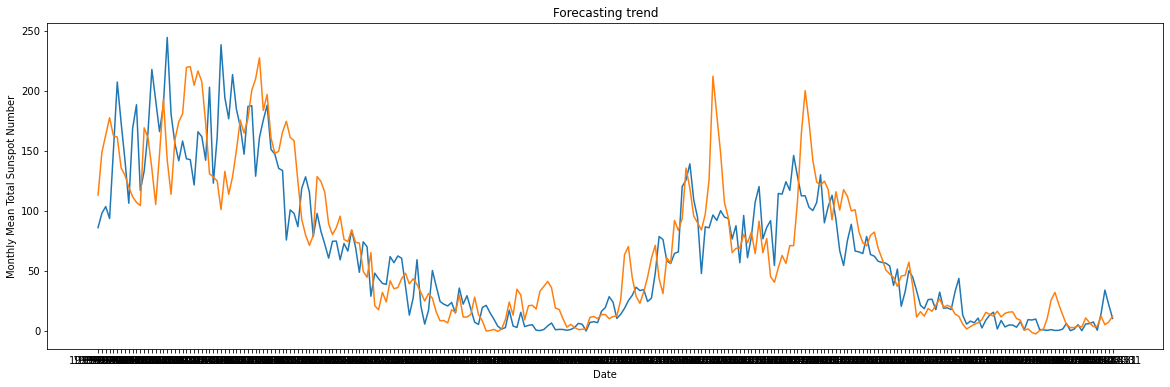

In [18]:
#Visualising on whole dataset
plt.figure(figsize=(20,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
plt.show()

In [19]:
results = np.array(rnn_forecast)

In [20]:
#Calculate mean absolute error
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

23.04484

#### Model 2 (Tuning)

In [21]:
#Defining the parameters
window_size = 50
batch_size = 100
shuffle_buffer_size = 1000

In [22]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

In [23]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)
np.random.seed(0)

#Using the windowing operator we can convert a time series problem into a machine learning problem.
#This allows us to use all the additional tools and techniques to train and optimize models.

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

dataset = windowed_dataset(x_train, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)

# Define the model

model_2 = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

model_2.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])

model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 64)          384       
                                                                 
 lstm (LSTM)                 (None, None, 64)          33024     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          33024     
                                                                 
 lstm_2 (LSTM)               (None, None, 64)          33024     
                                                                 
 dense (Dense)               (None, None, 32)          2080      
                                                                 
 dense_1 (Dense)             (None, None, 16)          528       
                                                                 
 dense_2 (Dense)             (None, None, 1)           1

In [24]:
%%time 
history = model_2.fit(dataset, epochs=100, verbose=1)

Epoch 1/100
30/30 [==============================] - 8s 133ms/step - loss: 28.2769 - mae: 28.7712
Epoch 2/100
30/30 [==============================] - 4s 139ms/step - loss: 19.9480 - mae: 20.4405
Epoch 3/100
30/30 [==============================] - 5s 159ms/step - loss: 19.0659 - mae: 19.5581
Epoch 4/100
30/30 [==============================] - 5s 157ms/step - loss: 17.8933 - mae: 18.3848
Epoch 5/100
30/30 [==============================] - 5s 147ms/step - loss: 17.3774 - mae: 17.8684
Epoch 6/100
30/30 [==============================] - 4s 130ms/step - loss: 17.3541 - mae: 17.8447
Epoch 7/100
30/30 [==============================] - 4s 140ms/step - loss: 17.0651 - mae: 17.5558
Epoch 8/100
30/30 [==============================] - 4s 133ms/step - loss: 16.6357 - mae: 17.1259
Epoch 9/100
30/30 [==============================] - 4s 123ms/step - loss: 16.5254 - mae: 17.0153
Epoch 10/100
30/30 [==============================] - 5s 145ms/step - loss: 16.3548 - mae: 16.8446
Epoch 11/100
30/30 

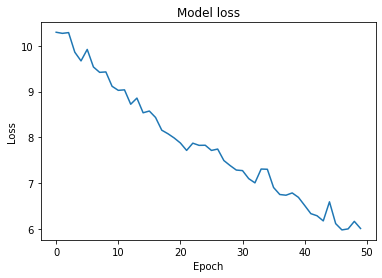

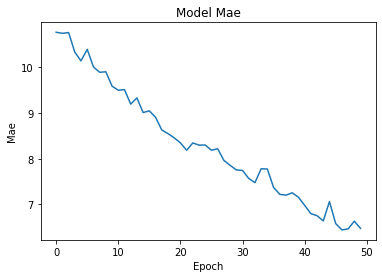

In [25]:
#Plotting loss values
plt.plot(history.history['loss'][50:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

#Plotting mae values
plt.plot(history.history['mae'][50:])
plt.title('Model Mae')
plt.ylabel('Mae')
plt.xlabel('Epoch')
plt.show()

In [26]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w : w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [27]:
#Predict the result
rnn_forecast = model_forecast(model_2, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [28]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.title('Forecasting trend')
    plt.xlabel('Date')
    plt.ylabel('Monthly Mean Total Sunspot Number')

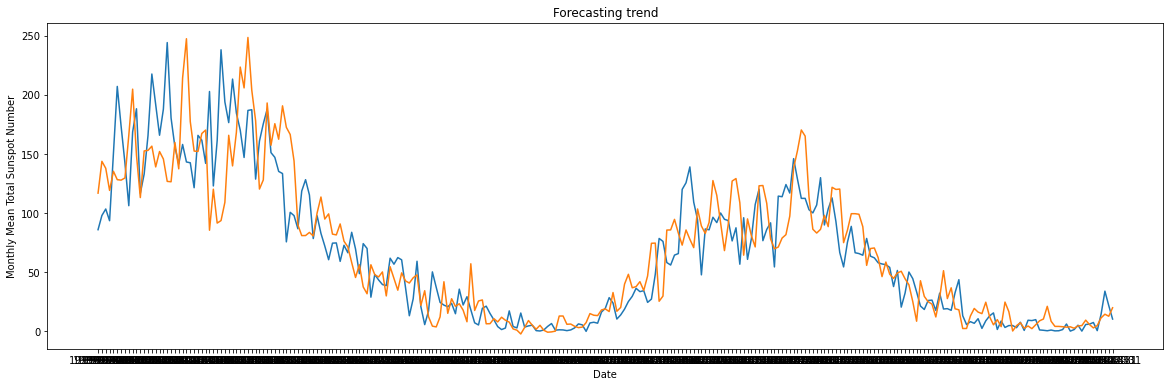

In [29]:
#Visualising on whole dataset
plt.figure(figsize=(20,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
plt.show()

In [30]:
results = np.array(rnn_forecast)

In [31]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

21.004541

#### Conslusion 
Mean absolute error of model 1 = 23.04 and model 2 = 21.00. Our tuning was successful and we improved the score a lot. 
In the first model we had bigger window size and batch size and training took a bit longer. However this did not result in better result. Decreasing the window size and batch size got us better result this time and also shorter training time. 

### Simple RNN

In [32]:
time_data = df['Date'].to_numpy()
series = df['Monthly Mean Total Sunspot Number'].to_numpy()

In [33]:
#Defining the parameters
window_size = 100
batch_size = 256
shuffle_buffer_size = 1000

In [34]:
split_time = 3000
time_train = time_data[:split_time]
x_train = series[:split_time]

time_valid = time_data[split_time:]
x_valid = series[split_time:]

In [35]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)
np.random.seed(0)

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

dataset = windowed_dataset(x_train, window_size=60, batch_size=64, shuffle_buffer=shuffle_buffer_size)

# Define the model

model_3 = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(64, return_sequences=True, activation="relu", input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(64, return_sequences=True, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1),
])


model_3.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])

model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, None, 64)          4224      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 64)          8256      
                                                                 
 dense (Dense)               (None, None, 32)          2080      
                                                                 
 dense_1 (Dense)             (None, None, 16)          528       
                                                                 
 dense_2 (Dense)             (None, None, 1)           17        
                                                                 
Total params: 15,105
Trainable params: 15,105
Non-trainable params: 0
_________________________________________________________________


In [36]:
%%time 
history = model_3.fit(dataset, epochs=100, verbose=1)

Epoch 1/100
46/46 [==============================] - 2s 20ms/step - loss: 27.8539 - mae: 28.3458
Epoch 2/100
46/46 [==============================] - 1s 22ms/step - loss: 17.8214 - mae: 18.3115
Epoch 3/100
46/46 [==============================] - 1s 22ms/step - loss: 17.4116 - mae: 17.9011
Epoch 4/100
46/46 [==============================] - 1s 23ms/step - loss: 17.2493 - mae: 17.7386
Epoch 5/100
46/46 [==============================] - 1s 22ms/step - loss: 17.0883 - mae: 17.5770
Epoch 6/100
46/46 [==============================] - 1s 22ms/step - loss: 16.9491 - mae: 17.4374
Epoch 7/100
46/46 [==============================] - 1s 22ms/step - loss: 16.7078 - mae: 17.1943
Epoch 8/100
46/46 [==============================] - 1s 22ms/step - loss: 16.5387 - mae: 17.0250
Epoch 9/100
46/46 [==============================] - 1s 22ms/step - loss: 16.3421 - mae: 16.8283
Epoch 10/100
46/46 [==============================] - 1s 24ms/step - loss: 16.2548 - mae: 16.7412
Epoch 11/100
46/46 [=========

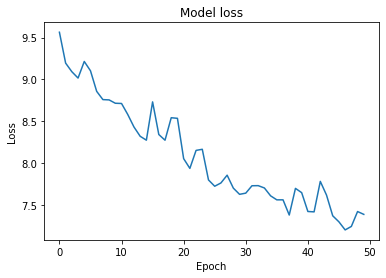

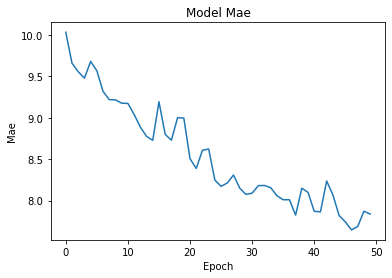

In [37]:
#Plotting loss values
plt.plot(history.history['loss'][50:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

#Plotting mae values
plt.plot(history.history['mae'][50:])
plt.title('Model Mae')
plt.ylabel('Mae')
plt.xlabel('Epoch')
plt.show()

In [38]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [39]:
#Predict the result
rnn_forecast = model_forecast(model_3, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [40]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.title('Forecasting trend')
    plt.xlabel('Date')
    plt.ylabel('Monthly Mean Total Sunspot Number')

In [41]:
test_df = df[(df['Date'] > '2018-08-01') & (df['Date'] <= '2019-12-31')] # date from aug 2018 to dec 2019 for testing 

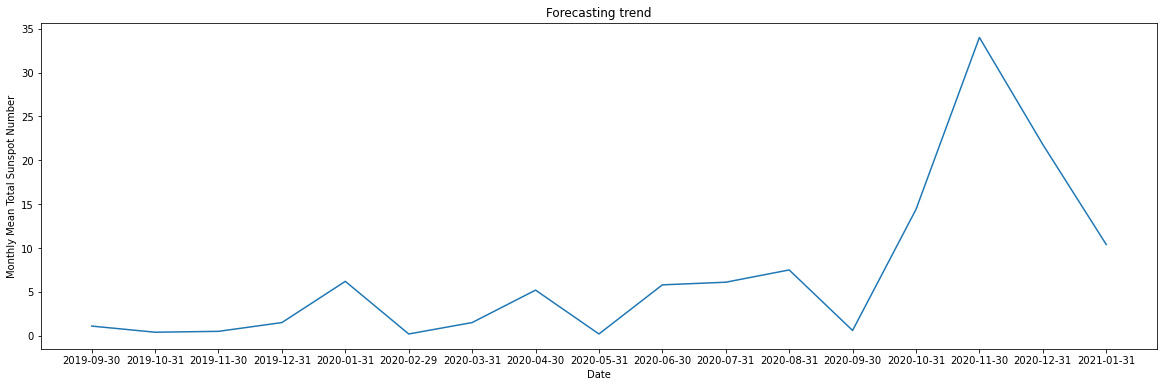

In [42]:
#Visualising the result
plt.figure(figsize=(20,6))
plot_series(time_valid[-len(test_df):], x_valid[-len(test_df):])

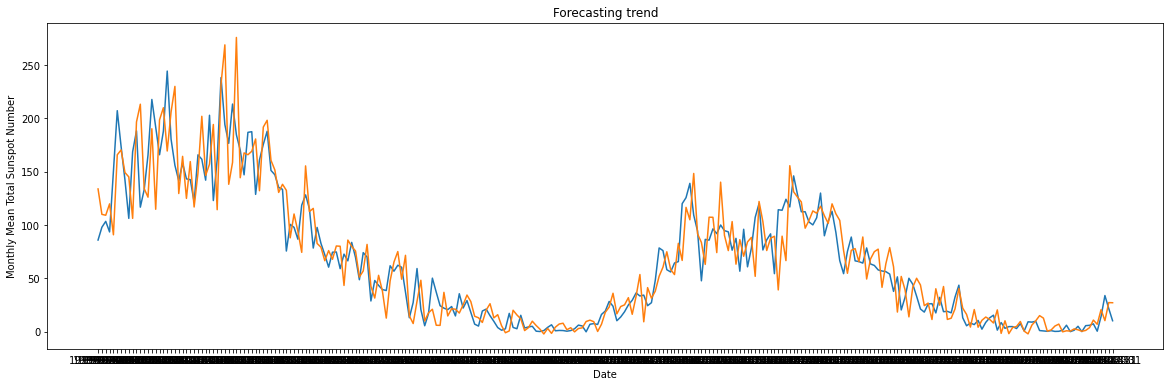

In [43]:
#Visualising on whole dataset
plt.figure(figsize=(20,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
plt.show()

In [44]:
results = np.array(rnn_forecast)

In [45]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

16.50681

### Comparing the two different models

The mean absolute error for LMST (for 100 epochs) was 21.00 <br>
The mean absolute error for Simple RNN (for 100 epochs) was 16.50 <br>
Therefore, Simple RNN is the better model